In [1]:
#import libraries
import warnings
warnings.filterwarnings('ignore')

import os
from pathlib import Path
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from PIL import Image
import cv2
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Input, Activation, Add, Dense, Conv2D, GlobalAveragePooling2D, MaxPooling2D
from keras.layers import BatchNormalization, Dropout
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Model
from keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import svm 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split 

2024-04-17 17:30:31.929114: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-17 17:30:31.929212: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-17 17:30:32.043428: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **EDA**

In [2]:
#Upload datset to Kaggle input directory
data_path= Path("/kaggle/input/team-14-garbage-dataset/TrashType_Image_Dataset-devaki")

In [3]:
# Total Images
sub_dir_join = list(data_path.glob("*/*.jpg"))
print(f"Total Images = {len(sub_dir_join)}")
print("**" * 15)
# Total Images per class
img_classes = (os.listdir(data_path))

for c in img_classes:
    imgs_class_count = len(list(Path(os.path.join(data_path, c)).glob("*.jpg")))
    print(f"* {c} :{imgs_class_count} images")

Total Images = 3600
******************************
* metal :600 images
* glass :600 images
* paper :600 images
* trash :600 images
* cardboard :600 images
* plastic :600 images


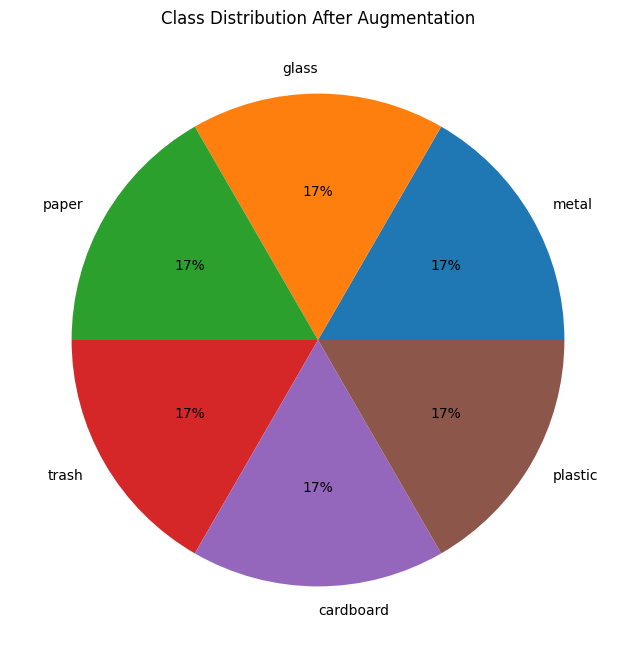

In [4]:
class_dis = [len(os.listdir(os.path.join(data_path, c))) for c in img_classes]
plt.figure(figsize=(10,8))
plt.pie(labels=img_classes, x=class_dis, autopct='%.0f%%')
plt.title("Class Distribution After Augmentation")
plt.show()

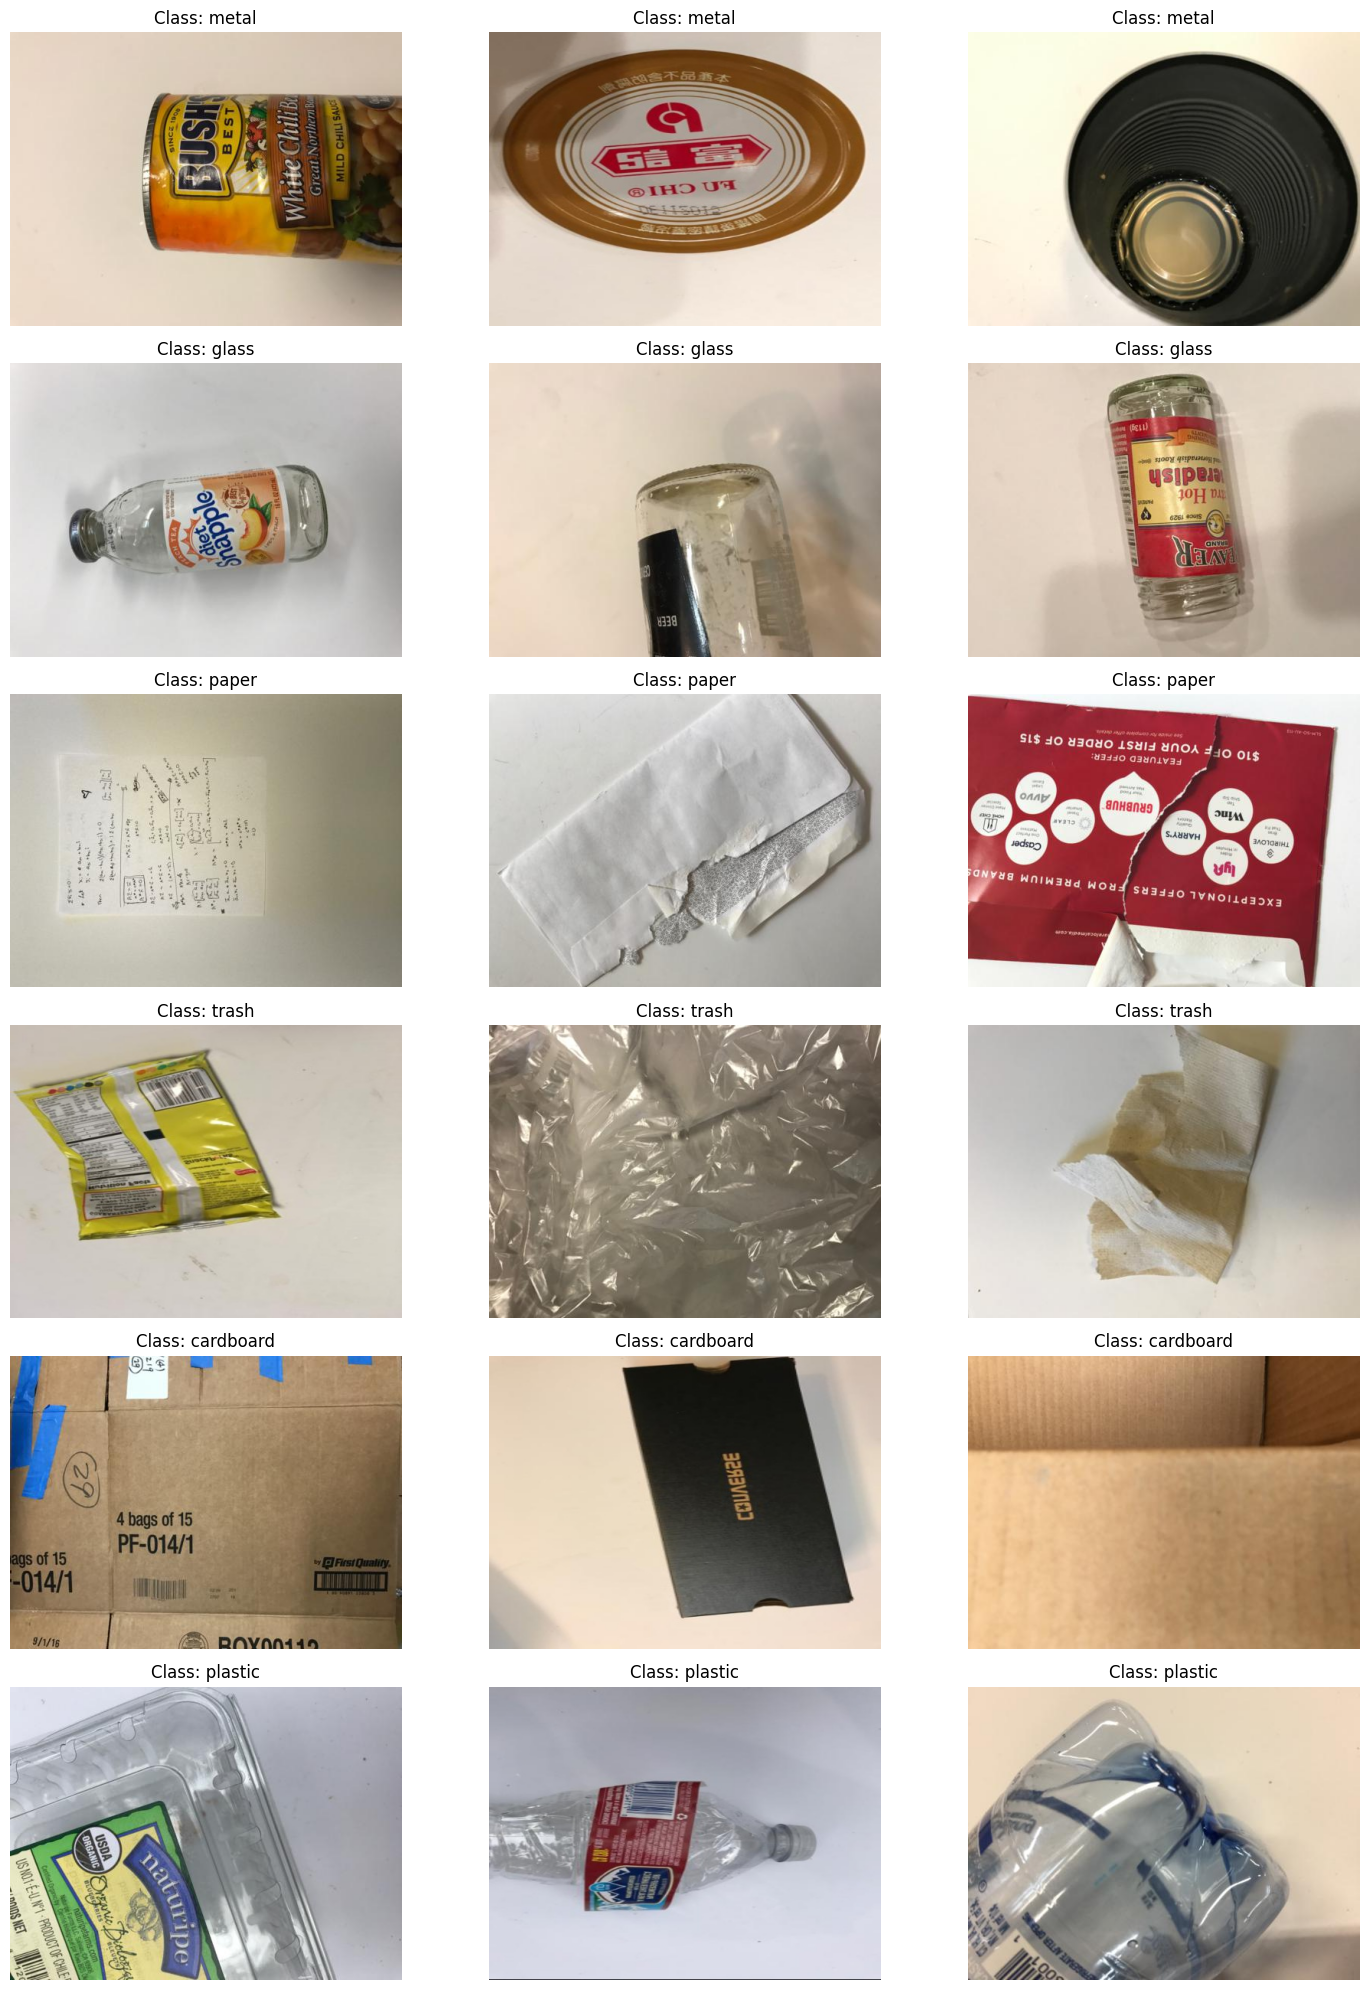

In [5]:
# select few images to display
fig, ax = plt.subplots(6, 3, figsize = (15, 20))
n = 0
for c in img_classes:
    imgs = list(Path(os.path.join(data_path, c)).glob("*.jpg"))
    imgs = imgs[0:3]
    
    for i,img in enumerate(imgs):
        img_bgr = cv2.imread(str(img))
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        ax[n,i].imshow(img_rgb)
        ax[n,i].set_title(f"Class: {c}")
        ax[n,i].axis("off")       
    n += 1
    
fig.tight_layout()
fig.show()

# **Data Preprocessing**

In [6]:
#convert data to data frame:
data = []
for img_class in img_classes:
    for file in os.listdir(os.path.join(data_path, img_class)):
        data.append((os.path.join(data_path, img_class, file), img_class))
df = pd.DataFrame(data, columns=['img_filepath', 'label'])
df.head()

img_filepath  label
0  /kaggle/input/team-14-garbage-dataset/TrashTyp...  metal
1  /kaggle/input/team-14-garbage-dataset/TrashTyp...  metal
2  /kaggle/input/team-14-garbage-dataset/TrashTyp...  metal
3  /kaggle/input/team-14-garbage-dataset/TrashTyp...  metal
4  /kaggle/input/team-14-garbage-dataset/TrashTyp...  metal

In [7]:
# Split with stratification
strat = df['label']
train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

# valid and test dataframe
strat = dummy_df['label']
valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

In [9]:
# Slight Augmentation settings for training
train_datagen = ImageDataGenerator(
    rescale=1./255,                     # Normalize pixel values to [0,1]
    rotation_range=45,                  # Randomly rotate the images by up to 45 degrees
    width_shift_range=0.15,             # Randomly shift images horizontally by up to 15% of the width
    height_shift_range=0.15,            # Randomly shift images vertically by up to 15% of the height
    zoom_range=0.15,                    # Randomly zoom in or out by up to 15%
    horizontal_flip=True,               # Randomly flip images horizontally
    vertical_flip=True,                 # Randomly flip images vertically
    shear_range=0.05,                   # Apply slight shear transformations
    brightness_range=[0.9, 1.1],        # Vary brightness between 90% to 110% of original
    channel_shift_range=10,             # Randomly shift channels (can change colors of images slightly but less aggressively)
    fill_mode='nearest'                 # Fill in missing pixels using the nearest filled value
)

# Only rescaling for validation
test_datagen = ImageDataGenerator(rescale=1./255)

In [72]:
# Using flow_from_dataframe to generate batches
# Generate training batches from the training dataframe
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,                  # DataFrame containing training data
    x_col="img_filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False,                        # Data is not shuffled; order retained from DataFrame
    subset="training"
)


# Generate validation batches from the validation dataframe
val_generator = test_datagen.flow_from_dataframe(
    dataframe=valid_df,                    # DataFrame containing validation data
    x_col="img_filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                     # Data is not shuffled; order retained from DataFrame
)

# Generate test batches from the validation dataframe
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,                    # DataFrame containing validation data
    x_col="img_filepath",                    # Column with paths to image files
    y_col="label",                       # Column with image labels
    target_size=(384, 384),              # Resize all images to size of 384x384
    batch_size=32,                       # Number of images per batch
    class_mode='categorical',            # One-hot encode labels
    seed=42,                             # Seed for random number generator to ensure reproducibility
    shuffle=False                      # Data is not shuffled; order retained from DataFrame
)


Found 2880 validated image filenames belonging to 6 classes.
Found 360 validated image filenames belonging to 6 classes.
Found 360 validated image filenames belonging to 6 classes.


# **Model Definition**

In [11]:
# Common
import os 
import keras
import numpy as np
import pandas as pd
import tensorflow as tf


# Data Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Model 
from keras.models import load_model, Sequential
from keras.layers import GlobalAvgPool2D as GAP, Dense, Dropout

# Callbacks 

from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

# Transfer Learning Model 
from tensorflow.keras.applications import ResNet50, ResNet50V2, ResNet152, ResNet152V2, InceptionV3, Xception

In [12]:
# Add EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True, verbose=1)

In [14]:
# Load Pretrained Model 
base_model = ResNet50V2(include_top=False, input_shape=(384,384,3))
base_model.trainable = False # Freeze weights

# Model Name
name = 'GarbageTypeClassifier-ResNet50V2'

# Model Architecture
model = Sequential([
    base_model,
    GAP(),
    Dense(384, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='softmax')
], name=name)

# Compilekm;
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks 
#cbs = [EarlyStopping(patience=3, restore_best_weights=True), ModelCheckpoint(name + ".h5", save_best_only=True)]

# Train
history = model.fit(train_generator, validation_data=val_generator, epochs=200,callbacks=early_stopping)

Epoch 1/200
 1/90 ━━━━━━━━━━━━━━━━━━━━ 46:47 32s/step - accuracy: 0.1250 - loss: 2.2366

I0000 00:00:1713375145.112253      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


90/90 ━━━━━━━━━━━━━━━━━━━━ 149s 1s/step - accuracy: 0.5872 - loss: 1.1070 - val_accuracy: 0.8472 - val_loss: 0.4276
Epoch 2/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.8293 - loss: 0.4725 - val_accuracy: 0.8861 - val_loss: 0.3834
Epoch 3/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 101s 1s/step - accuracy: 0.8516 - loss: 0.4126 - val_accuracy: 0.9167 - val_loss: 0.3114
Epoch 4/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.8828 - loss: 0.3279 - val_accuracy: 0.8917 - val_loss: 0.2972
Epoch 5/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.8959 - loss: 0.2758 - val_accuracy: 0.9111 - val_loss: 0.2886
Epoch 6/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9060 - loss: 0.2668 - val_accuracy: 0.9250 - val_loss: 0.2754
Epoch 7/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9288 - loss: 0.2298 - val_accuracy: 0.9222 - val_loss: 0.2807
Epoch 8/200
90/90 ━━━━━━━━━━━━━━━━━━━━ 102s 1s/step - accuracy: 0.9178 - loss: 0.2289 - val_accuracy: 0.9278 - val_l

In [30]:
model.summary()

Model: "GarbageTypeClassifier-ResNet50V2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 12, 12, 2048)   │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 384)            │       786,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 384)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         2,310 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,932,180 (98.92 MB)

 Trainable params: 789,126 (3.01 MB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 1,578,254 (6.02 MB)

# **Model Evaluation**

In [34]:
results = model.evaluate(test_generator, verbose=0)
results

[0.24993298947811127, 0.925000011920929]

In [ ]:
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

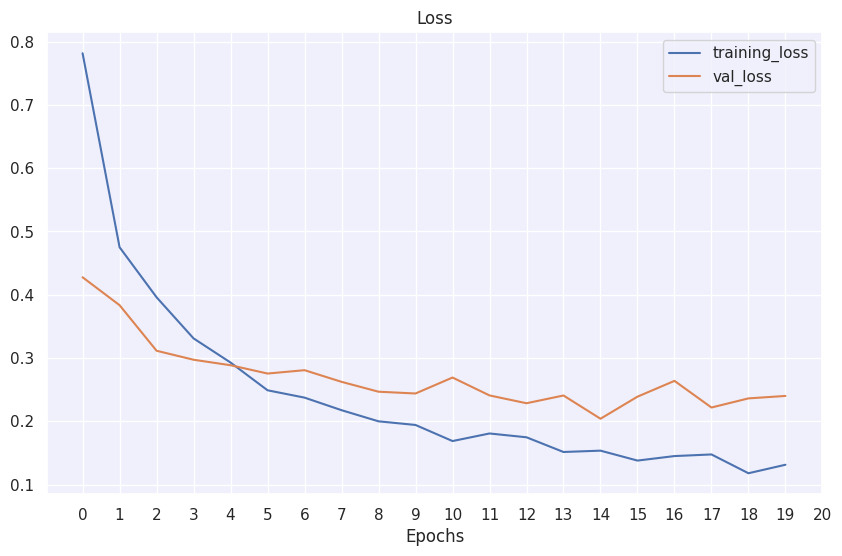

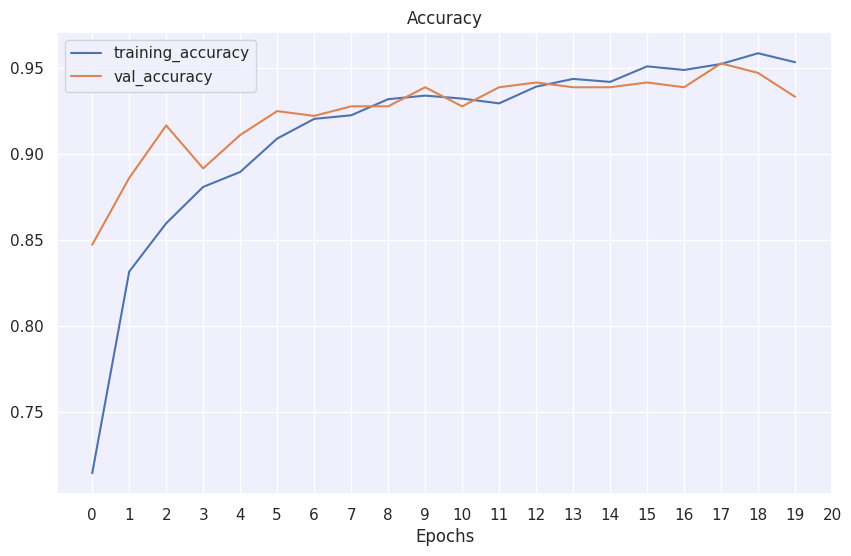

In [29]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(history.history['loss']))


# Plot loss
plt.figure(figsize=(10,6))
plt.plot(epochs, loss, label='training_loss')
plt.plot(epochs, val_loss, label='val_loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.xticks(range(0, 21))
plt.legend()

# Plot accuracy
plt.figure(figsize=(10,6))
plt.plot(epochs, accuracy, label='training_accuracy')
plt.plot(epochs, val_accuracy, label='val_accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.xticks(range(0, 21))
plt.legend();
plt.show()

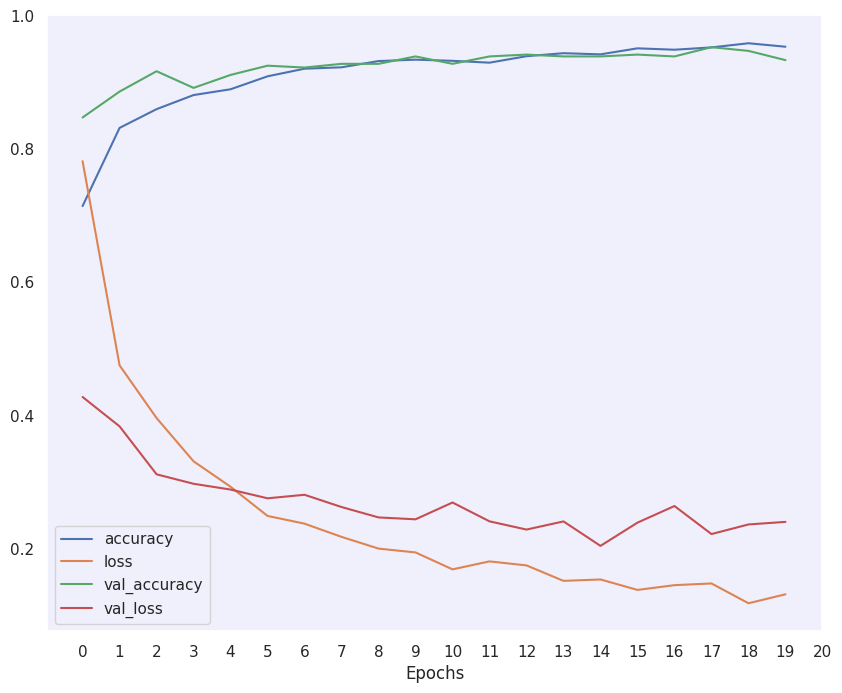

In [33]:
pd.DataFrame(history.history).plot(figsize=(10,8))
plt.xticks(range(0, 21))
plt.xlabel('Epochs')
plt.grid()
plt.show()

In [38]:
def evaluate_model_performance(model, test_generator, class_labels):
    
    true_labels = test_generator.classes

    class_labels = list(test_generator.class_indices.keys())
 
    predictions = model.predict(test_generator, steps=len(test_generator))

    predicted_labels = np.argmax(predictions, axis=1)
    
  
    true_labels = test_generator.classes

    # Classification report
    report = classification_report(true_labels, predicted_labels, target_names=class_labels)
    print(report)
    print('\n')

    colors = ["white", "royalblue"]
    cmap_cm = LinearSegmentedColormap.from_list("cmap_cm", colors)

    # Confusion Matrix
    cm = confusion_matrix(true_labels, predicted_labels)

    # Plotting confusion matrix using seaborn
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, cmap=cmap_cm, fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 160ms/step
              precision    recall  f1-score   support

   cardboard       0.96      0.90      0.93        60
       glass       0.95      0.88      0.91        60
       metal       0.93      0.92      0.92        60
       paper       0.93      0.93      0.93        60
     plastic       0.84      0.93      0.88        60
       trash       0.95      0.98      0.97        60

    accuracy                           0.93       360
   macro avg       0.93      0.92      0.93       360
weighted avg       0.93      0.93      0.93       360





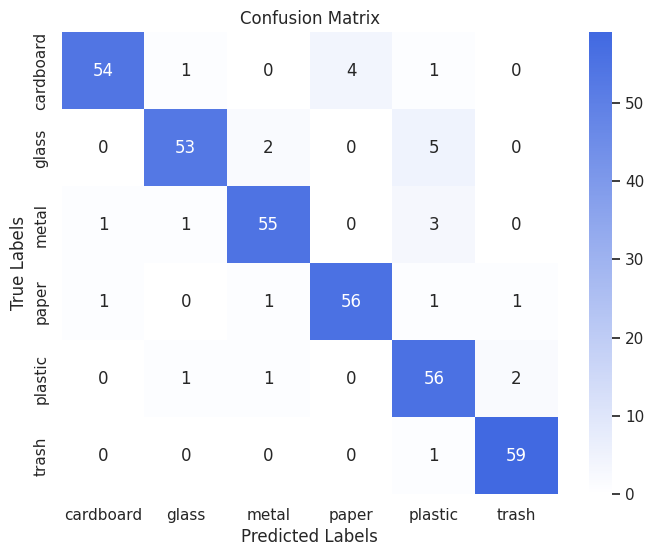

In [73]:
evaluate_model_performance(model, test_generator, img_classes)

In [78]:
pred = model.predict(test_generator)
pred = np.argmax(pred,axis=1)

# Map the label
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

# Display the result
print(f'The first 10 predictions: {pred[:10]}')

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step
The first 10 predictions: ['cardboard', 'cardboard', 'glass', 'plastic', 'paper', 'trash', 'trash', 'cardboard', 'paper', 'trash']


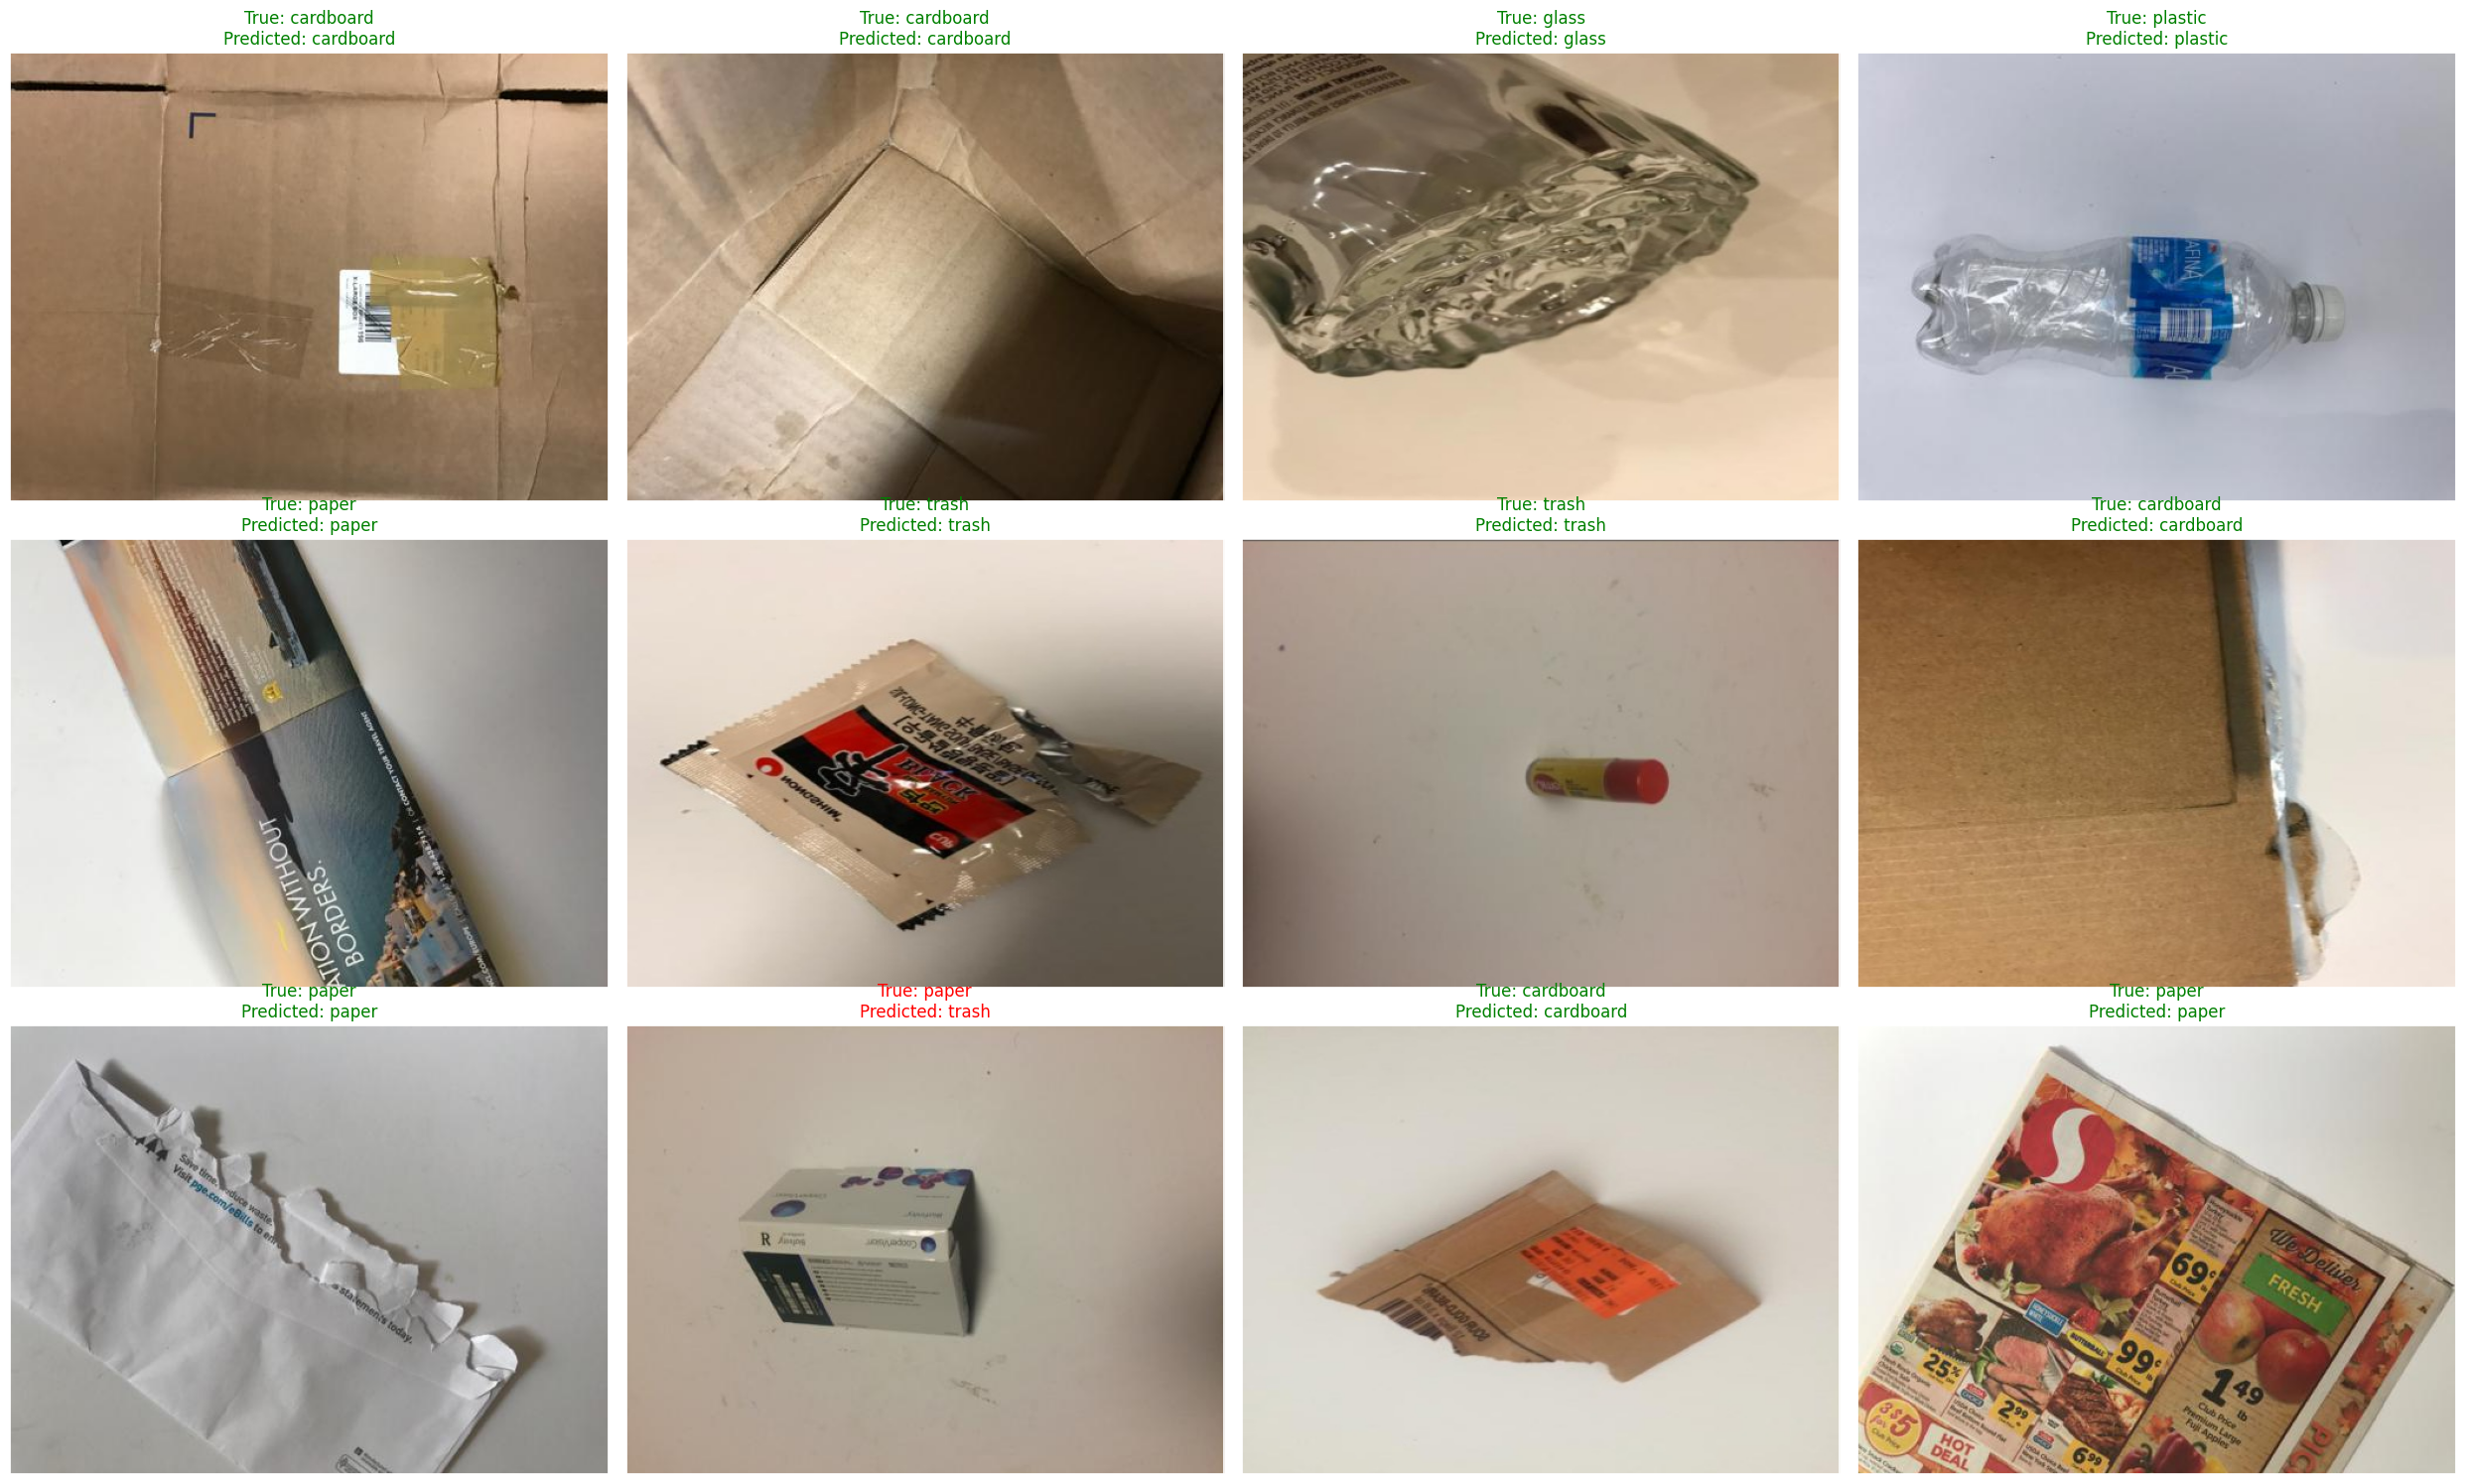

In [82]:

fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(25, 15),
                        subplot_kw={'xticks': [], 'yticks': []})
for i in range(0,13):
    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_generator.filepaths[i]))
        if labels[test_generator.labels[i]] == pred[i]:
            color = "green"
        else:
            color = "red"
        ax.set_title(f"True: {labels[test_generator.labels[i]]}\nPredicted: {pred[i]}", color=color)
plt.tight_layout()
plt.show()
# Reshuffle the indices for the next iteration
random.shuffle(random_index)

# **Testing on images taken by us**

In [96]:

test_new_datagen = ImageDataGenerator(rescale=1./255)  # You may need to adjust preprocessing steps
my_test_dir = '/kaggle/input/my-test-images'
image_files = [f for f in os.listdir(my_test_dir) if os.path.isfile(os.path.join(my_test_dir, f))]

# Create a generator for test images
my_test_generator = test_new_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame(image_files, columns=['filename']),
    directory=my_test_dir,
    x_col='filename',
    target_size=(384, 384),
    batch_size=1,  # Set batch size to 1 since there's only one image per batch
    class_mode=None,  
    shuffle=False) 

# Make predictions on the test images
pred = model.predict(my_test_generator)
# Get the predicted class indices
pred_classes = np.argmax(pred, axis=1)

Found 8 validated image filenames.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


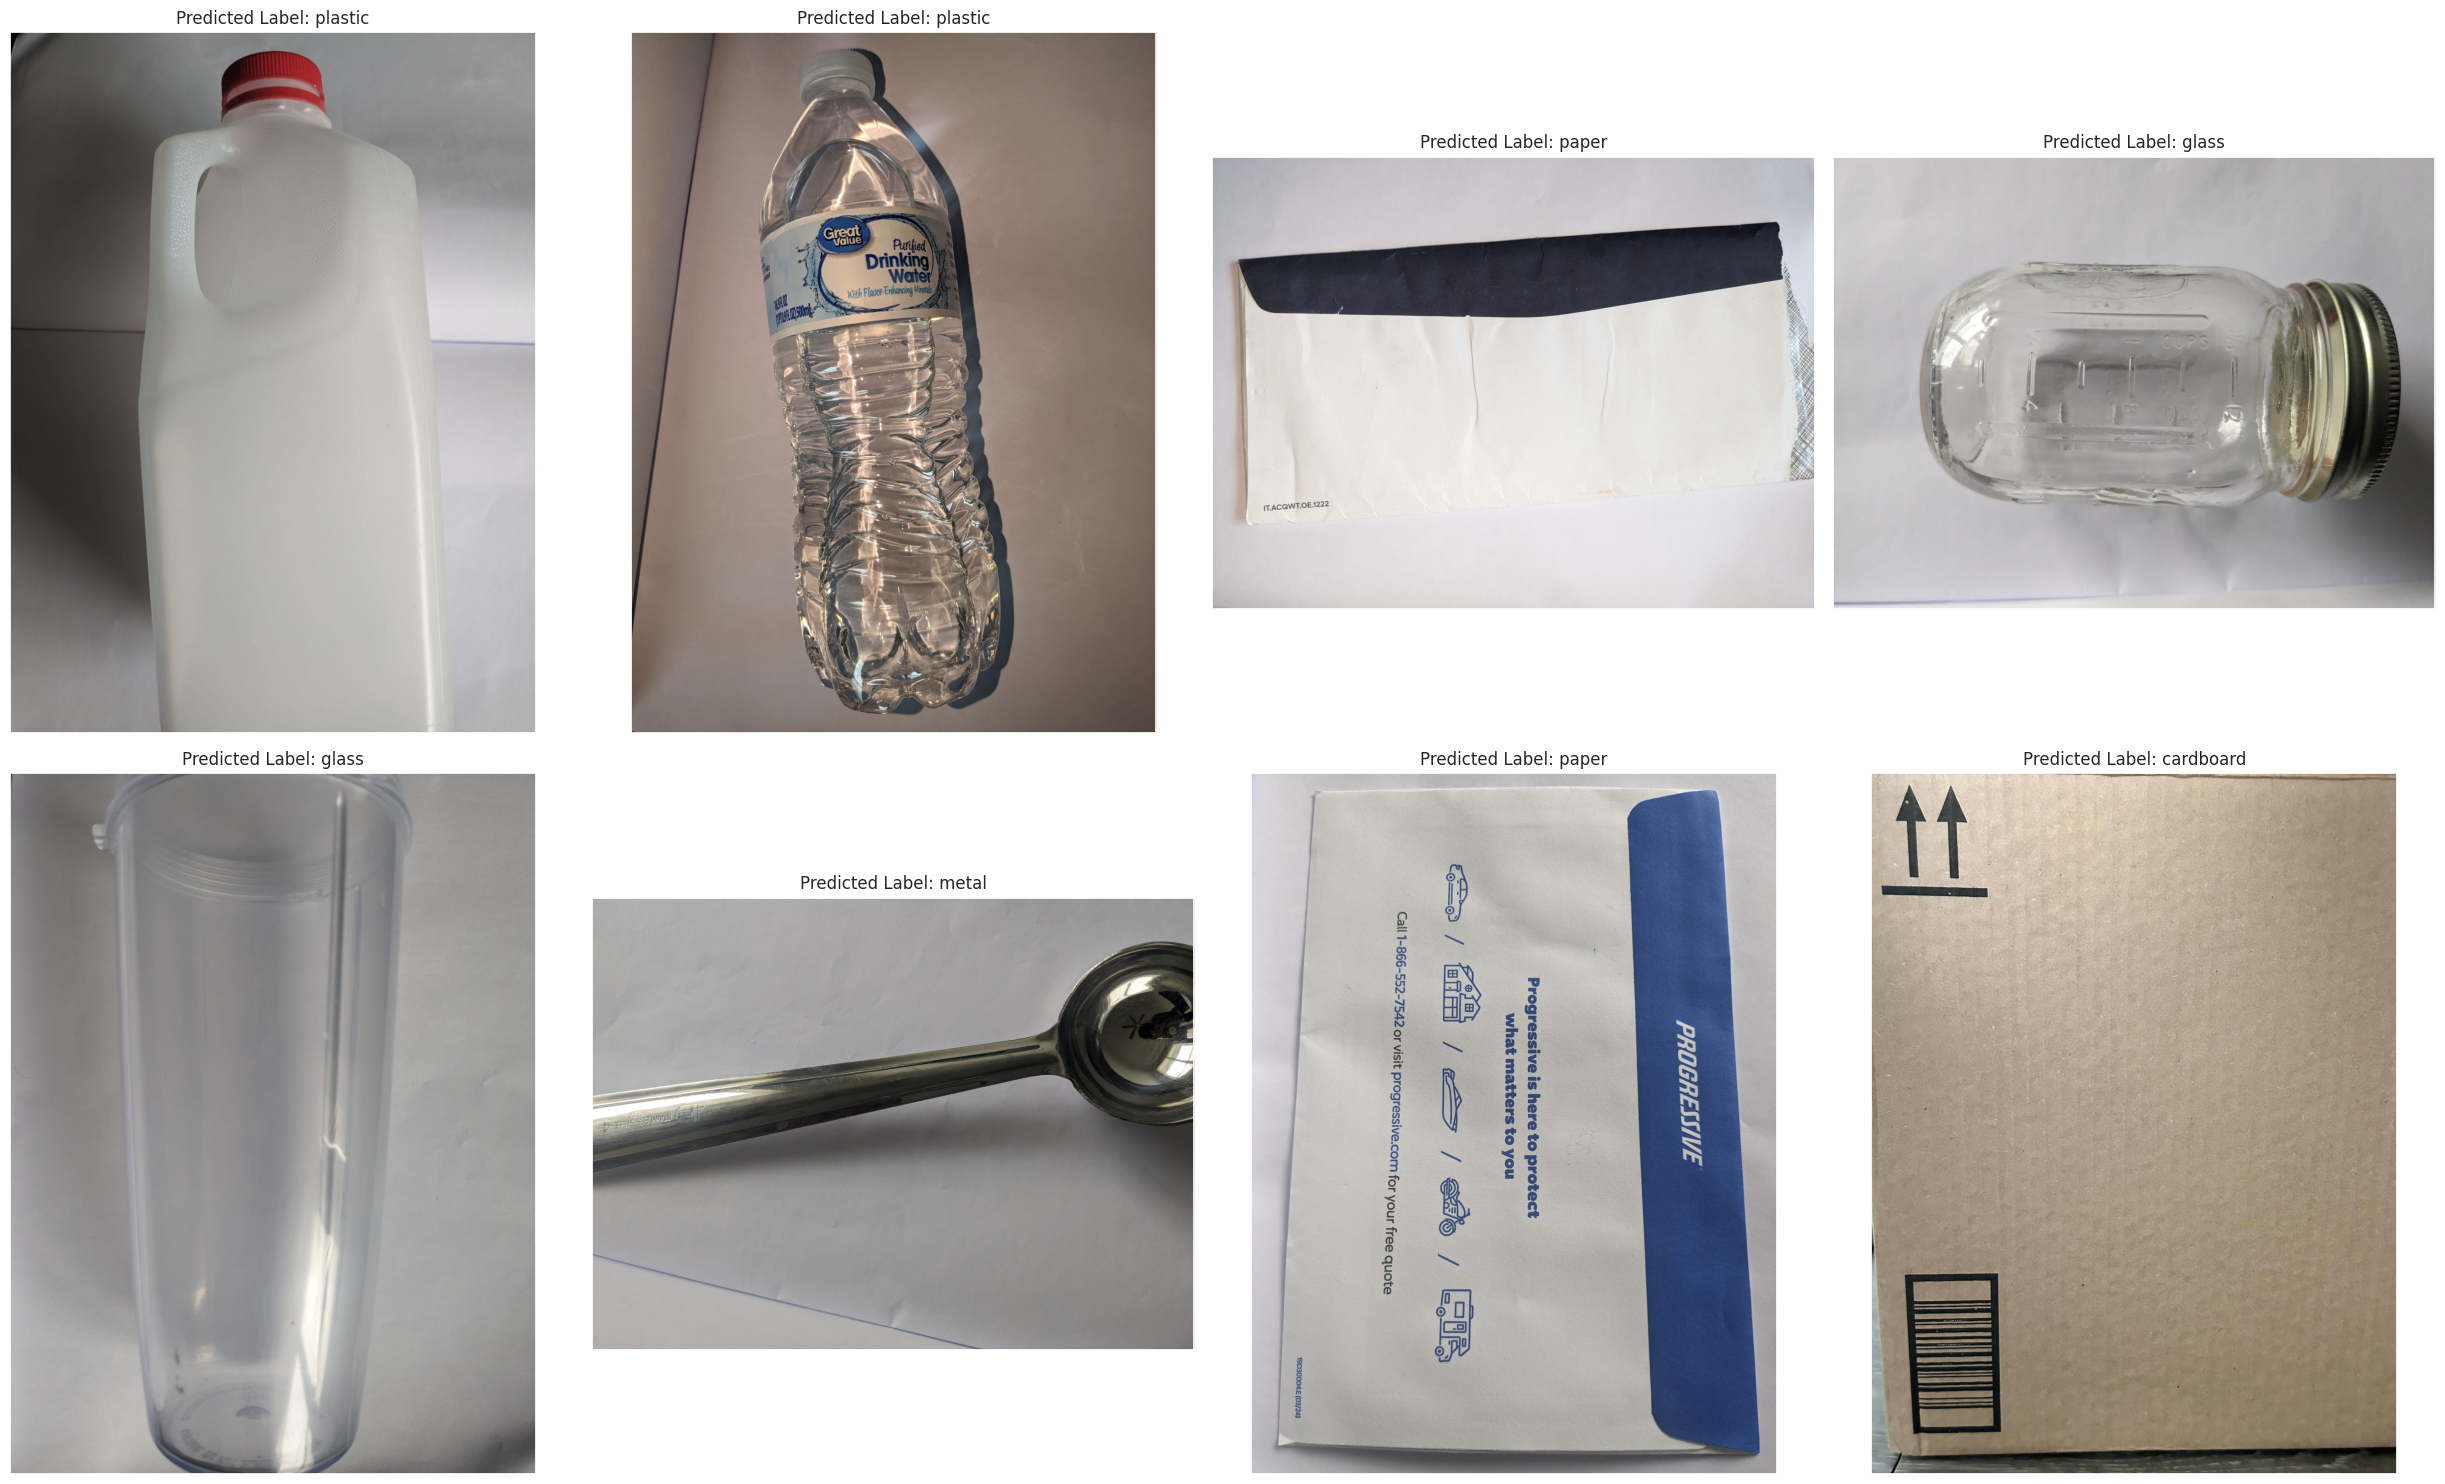

In [98]:
# Display the images along with predicted labels
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(25, 15))

for i, ax in enumerate(axes.flat):
    # Plot the image
    ax.imshow(plt.imread(my_test_generator.filepaths[i]))
    
    # Get the predicted label
    pred_label = labels[pred_classes[i]]  # Assuming 'labels' dictionary is defined
    
    # Set the title with the predicted label
    ax.set_title(f'Predicted Label: {pred_label}')
    
    # Remove ticks
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()